In [ ]:
from __future__ import annotations

import random
import sys
import os
import numpy as np
import torch
from math import ceil, exp, log
from pathlib import Path
import logging
import time
from tqdm import tqdm

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
class Config:
    def __init__(self):
        self.save = "/content/advection/"
        self.dt_save = 0.01
        self.ini_time = 0.0
        self.fin_time = 2.0
        self.nx = 1024
        self.xL = 0.0
        self.xR = 1.0
        self.beta = 1.0e0
        self.if_show = 1
        self.numbers = 100
        self.CFL = 4.0e-1
        self.if_second_order = 1.0
        self.show_steps = 100
        self.init_key = 2022
        self.if_rand_param = False
        self.batch_size = 5

In [ ]:
def bc(u, Ncell, mode="periodic", device=None):
    _u = torch.zeros(Ncell + 4, device=device)
    _u[2:Ncell+2] = u
    if mode == "periodic":
        _u[0:2] = u[-2:]
        _u[Ncell+2:Ncell+4] = u[0:2]
    elif mode == "reflection":
        _u[0] = -u[3]
        _u[1] = -u[2]
        _u[-2] = -u[-3]
        _u[-1] = -u[-4]
    elif mode == "copy":
        _u[0] = u[3]
        _u[1] = u[2]
        _u[-2] = u[-3]
        _u[-1] = u[-4]
    return _u

def Courant(u, dx):
    return dx / (torch.max(torch.abs(u)) + 1.0e-8)

def VLlimiter(a, b, c, alpha=2.0):
    return (
        torch.sign(c)
        * (0.5 + 0.5 * torch.sign(a * b))
        * torch.minimum(alpha * torch.minimum(torch.abs(a), torch.abs(b)), torch.abs(c))
    )

def limiting(u, Ncell, if_second_order):
    du_L = u[1:Ncell+3] - u[0:Ncell+2]
    du_R = u[2:Ncell+4] - u[1:Ncell+3]
    du_M = (u[2:Ncell+4] - u[0:Ncell+2]) * 0.5
    gradu = VLlimiter(du_L, du_R, du_M) * if_second_order

    uL = torch.zeros_like(u)
    uR = torch.zeros_like(u)
    uL[1:Ncell+3] = u[1:Ncell+3] - 0.5 * gradu
    uR[1:Ncell+3] = u[1:Ncell+3] + 0.5 * gradu
    return uL, uR

def init_multi(
    xc, numbers=10000, k_tot=8, init_key=2022, num_choise_k=2, if_norm=False, device='cuda'
):
    np.random.seed(init_key)
    torch.manual_seed(init_key)

    # Generate selected k values
    selected = np.random.randint(0, k_tot, size=(numbers, num_choise_k))
    selected_one_hot = np.zeros((numbers, k_tot), dtype=int)
    for i in range(numbers):
        for j in range(num_choise_k):
            selected_one_hot[i, selected[i, j]] = 1

    # Convert to PyTorch and move to device
    selected_one_hot = torch.tensor(selected_one_hot, device=device)
    xc_tensor = torch.tensor(xc, device=device)

    # Calculate kk values with broadcasting
    k_values = torch.arange(1, k_tot + 1, device=device) * (2.0 * torch.pi / (xc[-1] - xc[0]))
    kk = selected_one_hot.float() * k_values.unsqueeze(0)

    # Generate amplitudes and phases directly on GPU
    amp = torch.rand((numbers, k_tot, 1), device=device)
    phs = 2.0 * torch.pi * torch.rand((numbers, k_tot, 1), device=device)

    # Calculate sine waves efficiently using broadcasting
    xc_expanded = xc_tensor.view(1, 1, -1)  # [1, 1, nx]
    kk_expanded = kk.view(numbers, k_tot, 1)  # [numbers, k_tot, 1]
    phs_expanded = phs  # [numbers, k_tot, 1]

    # Generate sine waves for all k values and sum
    sin_waves = amp * torch.sin(kk_expanded * xc_expanded + phs_expanded)
    _u = torch.sum(sin_waves, dim=1)  # Sum over k dimension

    # Apply conditional absolute value
    cond_abs = torch.rand(numbers, device=device) < 0.1
    _u[cond_abs] = torch.abs(_u[cond_abs])

    # Apply random sign
    sgn = torch.randint(0, 2, (numbers, 1), device=device) * 2 - 1  # -1 or 1
    _u = _u * sgn

    # Apply window function to some solutions
    cond_window = torch.rand(numbers, device=device) < 0.1
    if torch.any(cond_window):
        xL = torch.rand(numbers, device=device) * 0.35 + 0.1  # 0.1 to 0.45
        xR = torch.rand(numbers, device=device) * 0.35 + 0.55  # 0.55 to 0.9
        trns = 0.01 * torch.ones(numbers, device=device)

        # Create masks for applicable indices
        for i in range(numbers):
            if cond_window[i]:
                mask = 0.5 * (torch.tanh((xc_tensor - xL[i]) / trns[i]) -
                             torch.tanh((xc_tensor - xR[i]) / trns[i]))
                _u[i] *= mask

    # Normalize if requested
    if if_norm:
        _u = _u - torch.min(_u, dim=1, keepdim=True)[0]
        _u = _u / torch.max(_u, dim=1, keepdim=True)[0]

    return _u

In [ ]:
def initialize_grids_and_conditions(cfg, device):
    dx = (cfg.xR - cfg.xL) / cfg.nx
    xe = np.linspace(cfg.xL, cfg.xR, cfg.nx + 1)
    xc = xe[:-1] + 0.5 * dx
    it_tot = ceil((cfg.fin_time - cfg.ini_time) / cfg.dt_save) + 1
    tc = np.arange(it_tot) * cfg.dt_save  # Match time points

    # Initial conditions
    u0 = init_multi(xc, numbers=cfg.numbers, k_tot=4, init_key=cfg.init_key, device=device)  # [N, X]

    return dx, xe, xc, tc, it_tot, u0

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cfg = Config()
dx, xe, xc, tc, it_tot, u0 = initialize_grids_and_conditions(cfg, device)

In [ ]:
print(u0.shape, xc.shape, tc.shape)

torch.Size([100, 1024]) (1024,) (201,)


NameError: name 'hi' is not defined

In [ ]:
def generate_analytical_groundtruth(cfg, xc, tc, u0, device):
    beta = cfg.beta
    L = cfg.xR - cfg.xL
    N, X = u0.shape
    T = len(tc)

    # Meshgrid for sampling
    xc_tensor = torch.tensor(xc, device=device).view(1, 1, -1)
    tc_tensor = torch.tensor(tc, device=device).view(-1, 1, 1)
    beta_tensor = torch.tensor(beta, device=device)

    x_shifted = (xc_tensor - beta_tensor * tc_tensor) % L
    x_norm = 2.0 * (x_shifted - cfg.xL) / (cfg.xR - cfg.xL) - 1.0
    y_dummy = torch.zeros_like(x_norm)
    grid = torch.stack((x_norm, y_dummy), dim=-1).expand(-1, u0.shape[0], -1, -1)
    grid = grid.permute(1, 0, 2, 3).unsqueeze(2).reshape(N * T, 1, X, 2)

    u0 = u0.unsqueeze(1).unsqueeze(2).expand(-1, -1, T, -1).reshape(N * T, 1, 1, X)

    sampled = torch.nn.functional.grid_sample(
        u0, grid, mode='bilinear', padding_mode='zeros', align_corners=True
    )

    uu_analytical = sampled.view(N, T, X)
    save_dir = cfg.save
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    np.save(save_dir + "1D_Advection_Sols_Analytical_beta" + str(beta)[:5], uu_analytical)
    return uu_analytical

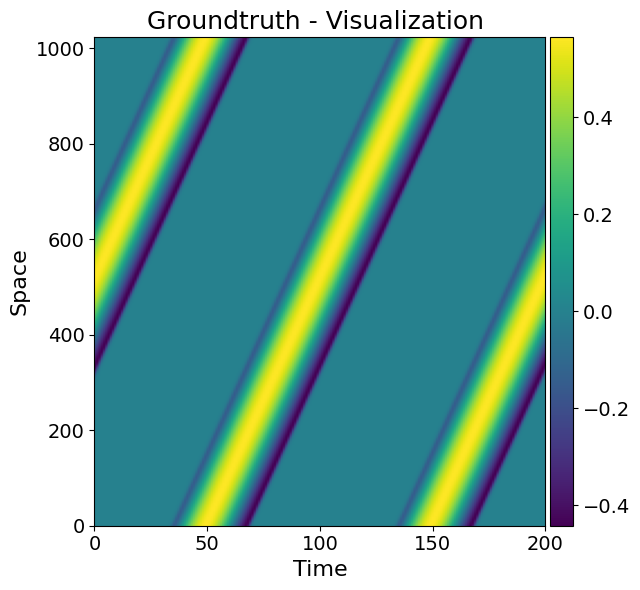

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch

# Example tensor [ICs, Time, Space]
# Assuming you already have your tensor loaded as `data`
# data = torch.randn(100, 201, 1024)  # Example
# You want to plot one initial condition
ic_index = 2  # Change this to select different initial conditions
data_ic = gt[ic_index]  # Shape: [201, 1024] (Time x Space)

# Transpose to shape [Space, Time] for imshow to match axes correctly
data_ic = data_ic.T  # Shape: [1024, 201]

# Define spatial and temporal ranges
t_min, t_max = 0, gt.shape[1] - 1
x_min, x_max = 0, gt.shape[2] - 1

fig, ax = plt.subplots(figsize=(6.5, 6))
h = ax.imshow(
    data_ic.cpu(),
    extent=[t_min, t_max, x_min, x_max],
    origin="lower",
    aspect="auto",
    cmap='viridis'
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=14)

ax.set_title(f"Groundtruth - Visualization ", fontsize=18)
ax.set_xlabel("Time", fontsize=16)
ax.set_ylabel("Space", fontsize=16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.show()

In [ ]:
cfg = Config()
gt = generate_analytical_groundtruth(cfg, xc, tc, u0, device)

In [ ]:
gt.shape

torch.Size([100, 201, 1024])

In [ ]:
gt.permute(1,0,2).shape

torch.Size([201, 100, 1024])

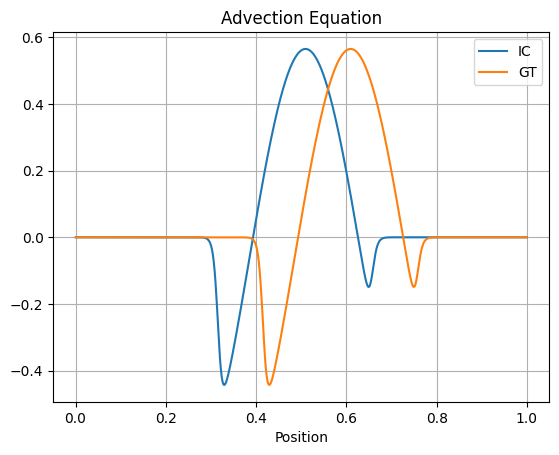

In [ ]:
import matplotlib.pyplot as plt

plt.plot(xc, u0[2], label=f'IC')
plt.plot(xc, gt[2, 10], label=f'GT')
plt.title('Advection Equation')
plt.xlabel('Position')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def main(cfg, dx, xe, xc, tc, it_tot, u0):
    # Check if CUDA is available
    if torch.cuda.is_available():
        device = torch.device('cuda')
        logger.info(f"Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device('cpu')
        logger.warning("CUDA not available, using CPU")

    # Basic parameters
    # dx = (cfg.xR - cfg.xL) / cfg.nx
    dx_inv = 1.0 / dx

    # Cell edge coordinate
    # xe = np.linspace(cfg.xL, cfg.xR, cfg.nx + 1)
    # # Cell center coordinate
    # xc = xe[:-1] + 0.5 * dx
    # # t-coordinate
    # it_tot = ceil((cfg.fin_time - cfg.ini_time) / cfg.dt_save) + 1
    # tc = np.arange(it_tot + 1) * cfg.dt_save

    ini_time = cfg.ini_time
    fin_time = cfg.fin_time
    dt_save = cfg.dt_save
    CFL = cfg.CFL
    if cfg.if_rand_param:
        beta = exp(random.uniform(log(0.01), log(100)))  # uniform number between 0.01 to 100
    else:
        beta = cfg.beta

    logger.info(f"beta: {beta}")
    beta_tensor = torch.tensor([beta], device=device)

    def flux(u_batch):
        """
        Compute flux for a batch of solutions
        u_batch: [batch_size, nx]
        """
        batch_size = u_batch.shape[0]
        fluxes = []

        # Process each solution in the batch
        for i in range(batch_size):
            # Apply boundary conditions
            _u = bc(u_batch[i], Ncell=cfg.nx, device=device)

            # Calculate limited values
            uL, uR = limiting(_u, cfg.nx, if_second_order=cfg.if_second_order)

            # Calculate fluxes
            fL = uL * beta_tensor
            fR = uR * beta_tensor

            # Upwind advection scheme
            f = 0.5 * (
                fR[1:cfg.nx+2]
                + fL[2:cfg.nx+3]
                - torch.abs(beta_tensor) * (uL[2:cfg.nx+3] - uR[1:cfg.nx+2])
            )

            fluxes.append(f)

        return torch.stack(fluxes)

    def update(u_batch, u_tmp_batch, dt):
        """
        Update the solution for a batch
        u_batch: [batch_size, nx]
        u_tmp_batch: [batch_size, nx]
        """
        f_batch = flux(u_tmp_batch)
        return u_batch - dt * dx_inv * (f_batch[:, 1:cfg.nx+1] - f_batch[:, 0:cfg.nx])

    def evolve_batch(u_init_batch):
        """
        Evolve a batch of initial conditions
        u_init_batch: [batch_size, nx]
        """
        batch_size = u_init_batch.shape[0]

        # Initialize variables
        t = ini_time
        tsave = t
        i_save = 0
        uu = torch.zeros(it_tot, batch_size, cfg.nx, device=device)
        uu[0] = u_init_batch

        # Current solution
        u_batch = u_init_batch.clone()

        # Main time loop
        while t < fin_time:
            # Save if needed
            if t >= tsave:
                uu[i_save] = u_batch
                tsave += dt_save
                i_save += 1

            # Run simulation for cfg.show_steps
            for _ in range(cfg.show_steps):
                # Calculate timestep
                dt = Courant(beta_tensor, dx) * CFL
                dt = min(dt.item(), fin_time - t, tsave - t)

                if dt > 1.0e-8:
                    # Predictor step
                    u_tmp_batch = update(u_batch.clone(), u_batch, dt * 0.5)
                    # Corrector step
                    u_batch = update(u_batch, u_tmp_batch, dt)

                t += dt

                if t >= fin_time or t >= tsave:
                    break

        # Final save if needed
        if i_save < it_tot:
            uu[i_save] = u_batch

        return uu

    # Initialize the solution on GPU
    start_time = time.time()
    logger.info("Generating initial conditions...")
    # u = init_multi(xc, numbers=cfg.numbers, k_tot=4, init_key=cfg.init_key, device=device)

    # Process in batches to manage GPU memory
    batch_size = min(cfg.batch_size, cfg.numbers)
    num_batches = (cfg.numbers + batch_size - 1) // batch_size

    logger.info(f"Processing {cfg.numbers} solutions in {num_batches} batches of size {batch_size}...")

    all_results = []
    for i in tqdm(range(num_batches), desc="Processing batches"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, cfg.numbers)

        if start_idx >= cfg.numbers:
            break

        logger.info(f"Processing batch {i+1}/{num_batches} ({start_idx} to {end_idx-1})...")

        batch_u = u0[start_idx:end_idx]

        # Process the batch on GPU
        batch_result = evolve_batch(batch_u)

        # Move to CPU for storage
        all_results.append(batch_result.cpu())

        # Free GPU memory
        torch.cuda.empty_cache()

    # Stack all results
    uu = torch.cat([res.permute(1, 0, 2) for res in all_results], dim=0)

    # Convert to numpy for saving
    uu_np = uu.numpy()

    logger.info(f"Computation complete in {time.time() - start_time:.2f} seconds")
    logger.info("Data saving...")
    save_dir = cfg.save
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    np.save(save_dir + "1D_Advection_Sols_beta" + str(beta)[:5], uu_np)
    np.save(save_dir + "x_coordinate", xc)
    np.save(save_dir + "t_coordinate", tc)

    return uu_np, xc, tc, beta

In [ ]:
os.makedirs("/content/advection/", exist_ok=True)

# Create configuration
cfg = Config()

# Run the main function
uu, xc, tc, beta = main(cfg)

Processing batches: 100%|██████████| 20/20 [09:15<00:00, 27.78s/it]


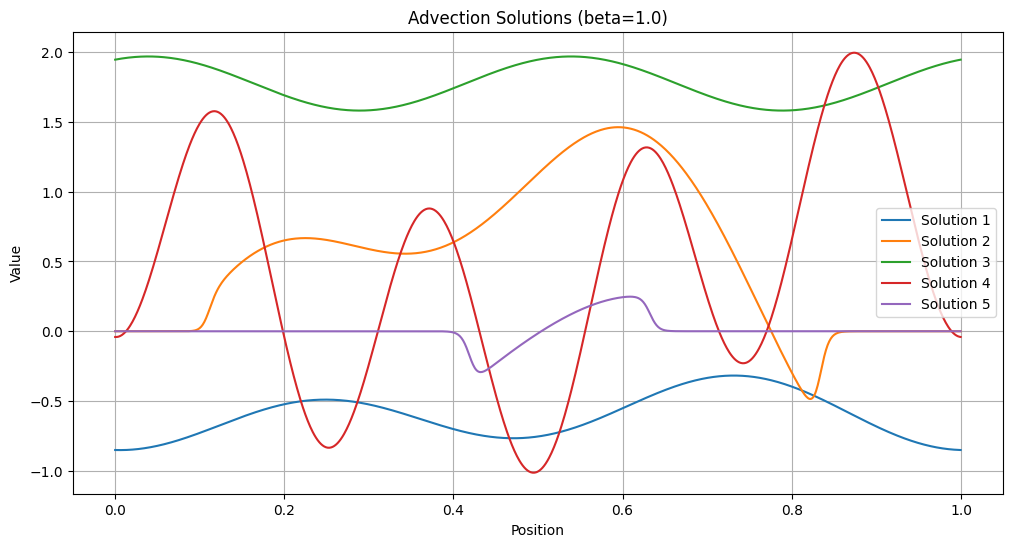

In [ ]:
 import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for i in range(min(5, uu.shape[0])):
    plt.plot(xc, uu[i, 0], label=f'Solution {i+1}')
plt.title(f'Advection Solutions (beta={beta})')
plt.xlabel('Position')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from pathlib import Path
import numpy as np
import h5py

# ==== Configuration (replace these manually or use argparse in CLI) ====
TYPE = "advection"     # Options: "advection", "burgers", "ReacDiff", "CFD"
DIM = 1               # 1, 2, or 3 for CFD or ReacDiff; always 1 for advection/burgers
BD = "periodic"       # Boundary condition: "periodic" or "trans"
NBATCH = 1000         # Number of training samples to use
SAVEDIR = "/content/advection/"

In [ ]:
def _mergeRD(var, DataND, savedir):
    _vars = ["2D", "nu"]
    if var not in _vars:
        return None

    idx = 0
    data_list = Path(savedir).glob(var + "*key*.npy")
    data_list.sort()
    for data_file in data_list:
        test = np.load(data_file).squeeze()
        batch = min(test.shape[0], DataND.shape[0] - idx)
        if var == "2D":
            DataND[idx : idx + batch] = test[:batch, -2]
        else:
            DataND[idx : idx + batch] = test[:batch]
        idx += batch

    return DataND[:idx]


def _merge(var, DataND, dim, savedir):
    if dim == 1:
        _vars = ["D", "P", "Vx"]
    elif dim == 2:
        _vars = ["D", "P", "Vx", "Vy"]
    elif dim == 3:
        _vars = ["D", "P", "Vx", "Vy", "Vz"]
    if var not in _vars:
        return None

    idx = 0
    data = Path(savedir).glob("HD*" + var + ".npy")
    data.sort()
    for data_file in data:
        test = np.load(data_file).squeeze()
        batch = min(test.shape[0], DataND.shape[0] - idx)
        DataND[idx : idx + batch] = test[:batch]
        idx += batch

    return DataND[:idx]


def nan_check(data):
    data = np.abs(data).reshape([data.shape[0], data.shape[1], -1]).sum(axis=-1)
    return np.where(data[:, -2] < 1.0e-6)[0], np.where(data[:, -2] > 1.0e-6)[0]


def merge(type, dim, bd, nbatch, savedir):
    if type == "CFD":
        data = Path(savedir).glob("HD*D.npy")
        data.sort()
        test = np.load(data[0])
        __nbatch, nt, nx, ny, nz = test.shape
        _nbatch = __nbatch * len(data)
        assert (
            nbatch <= _nbatch
        ), "nbatch should be equal or less than the number of generated samples"
        assert (
            2 * nbatch > _nbatch
        ), "2*nbatch should be larger than the number of generated samples"

        if dim == 1:
            DataND = np.zeros([2 * nbatch, nt, nx], dtype=np.float32)
            vars = ["D", "P", "Vx"]
        elif dim == 2:
            DataND = np.zeros([2 * nbatch, nt, nx, ny], dtype=np.float32)
            vars = ["D", "P", "Vx", "Vy"]
        elif dim == 3:
            DataND = np.zeros([2 * nbatch, nt, nx, ny, nz], dtype=np.float32)
            vars = ["D", "P", "Vx", "Vy", "Vz"]

    elif type == "ReacDiff":
        data = Path(savedir).glob("nu*.npy")
        data.sort()
        test = np.load(data[0])
        __nbatch, nx, ny = test.shape
        _nbatch = __nbatch * len(data)
        assert (
            nbatch == _nbatch
        ), "nbatch should be equal or less than the number of generated samples"
        DataND = np.zeros([nbatch, nx, ny], dtype=np.float32)
        vars = ["2D", "nu"]

    for var in vars:
        if type == "CFD":
            _DataND = _merge(var, DataND, dim, savedir)
            if var == "D":
                idx_neg, idx_pos = nan_check(_DataND)
                if len(idx_pos) < nbatch:
                    pass
            _DataND = _DataND[idx_pos]
            _DataND = _DataND[:nbatch]
            np.save(savedir + "/" + var + ".npy", _DataND)
        elif type == "ReacDiff":
            DataND = _mergeRD(var, DataND, savedir)
            np.save(savedir + "/" + var + ".npy", DataND)

    data = Path(savedir).glob("*npy")
    data.sort()

    if type == "CFD":
        zcrd = np.load(data[-1])
        del data[-1]
    ycrd = np.load(data[-1])
    del data[-1]
    xcrd = np.load(data[-1])
    del data[-1]
    tcrd = np.load(data[-1])
    del data[-1]
    if type == "ReacDiff":
        # data = glob.glob('save/' + type + '/nu*key*npy')
        data = Path(savedir).glob("nu*key*npy")
        data.sort()
        _beta = data[0].split("/")[-1].split("_")[3]
        flnm = savedir + "/2D_DecayFlow_" + _beta + "_Train.hdf5"
        with h5py.File(flnm, "w") as f:
            f.create_dataet("tensor", data=np.load(savedir + "/2D.npy")[:, None, :, :])
            f.create_dataet("nu", data=np.load(savedir + "/nu.npy"))
            f.create_dataet("x-coordinate", data=xcrd)
            f.create_dataet("y-coordinate", data=ycrd)
            f.attrs["beta"] = float(_beta[4:])
        return 0

    mode = data[1].split("/")[-1].split("_")[3]
    _eta = data[1].split("/")[-1].split("_")[4]
    _zeta = data[1].split("/")[-1].split("_")[5]
    _M = data[1].split("/")[-1].split("_")[6]
    if dim == 1:
        flnm = (
            savedir
            + "/1D_CFD_"
            + mode
            + "_"
            + _eta
            + "_"
            + _zeta
            + "_"
            + bd
            + "_Train.hdf5"
        )
    elif dim == 2:
        flnm = (
            savedir
            + "/2D_CFD_"
            + mode
            + "_"
            + _eta
            + "_"
            + _zeta
            + "_"
            + _M
            + "_"
            + bd
            + "_Train.hdf5"
        )
    elif dim == 3:
        flnm = (
            savedir
            + "/3D_CFD_"
            + mode
            + "_"
            + _eta
            + "_"
            + _zeta
            + "_"
            + _M
            + "_"
            + bd
            + "_Train.hdf5"
        )

    del DataND

    with h5py.File(flnm, "w") as f:
        f.create_dataet("density", data=np.load(savedir + "/D.npy"))
        f.create_dataet("pressure", data=np.load(savedir + "/P.npy"))
        f.create_dataet("Vx", data=np.load(savedir + "/Vx.npy"))
        if dim > 1:
            f.create_dataet("Vy", data=np.load(savedir + "/Vy.npy"))
            f.create_dataet("y-coordinate", data=ycrd)
        if dim == 3:
            f.create_dataet("Vz", data=np.load(savedir + "/Vz.npy"))
            f.create_dataet("z-coordinate", data=zcrd)
        f.create_dataet("x-coordinate", data=xcrd)
        f.create_dataet("t-coordinate", data=tcrd)
        eta = float(_eta[3:])
        zeta = float(_zeta[4:])
        f.attrs["eta"] = eta
        f.attrs["zeta"] = zeta
        if dim > 1:
            M = float(_M[1:])
            f.attrs["M"] = M
            return None
        return None


def transform(type, savedir):
    data = Path(savedir).glob("*npy")
    data.sort()
    xcrd = np.load(data[-1])
    del data[-1]
    tcrd = np.load(data[-1])
    del data[-1]

    flnm = data[0]
    with h5py.File(flnm[:-3] + "hdf5", "w") as f:
        _data = np.load(flnm)

        f.create_dataset("tensor", data=_data.astype(np.float32))
        f.create_dataset("x-coordinate", data=xcrd)
        f.create_dataset("t-coordinate", data=tcrd)
        if type == "advection":
            beta = float(flnm.split("/")[-1].split("_")[3][4:-4])  # advection train
            f.attrs["beta"] = beta

        elif type == "burgers":
            Nu = float(flnm.split("/")[-1].split("_")[-1][2:-4])  # Burgers test/train
            f.attrs["Nu"] = Nu

        elif type == "ReacDiff":
            Rho = float(flnm.split("/")[-1].split("_")[-1][3:-4])  # reac-diff test
            Nu = float(flnm.split("/")[-1].split("_")[-2][2:])  # reac-diff test
            f.attrs["Nu"] = Nu
            f.attrs["rho"] = Rho

In [ ]:
pde1ds = ["advection", "burgers", "ReacDiff"]
if TYPE in pde1ds and DIM == 1:
    transform(type=TYPE, savedir=SAVEDIR)
else:
    bds = ["periodic", "trans"]
    assert BD in bds, "bd should be either periodic or trans"
    merge(type=TYPE, dim=DIM, bd=BD, nbatch=NBATCH, savedir=SAVEDIR)

AttributeError: 'generator' object has no attribute 'sort'

In [ ]:
import numpy as np

In [ ]:
data = np.load("predictions_for_sindy.npz")
u_pred = data["u_pred"]                # (n_x,)
t = data["t"]

BadZipFile: File is not a zip file